In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [2]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [120]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states, steps=steps, rec_strength=5.0)

In [121]:
#place_inputs += (np.random.randn(num_states, N_inp))/2

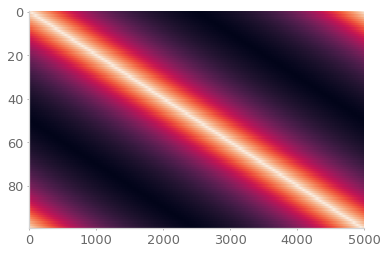

In [122]:
plt.figure()
plt.imshow(place_inputs, aspect='auto')
plt.show()

In [ ]:
cache_states = [n*2 for n in range(50)]

# Run Task (no learning)

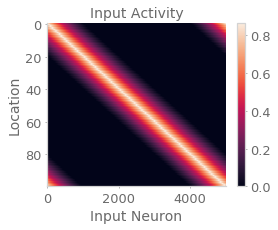

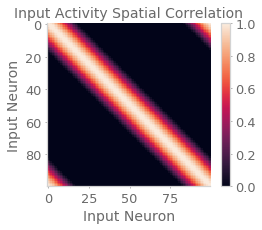

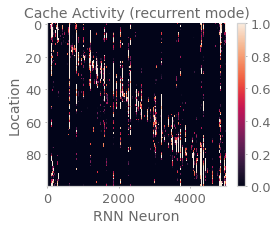

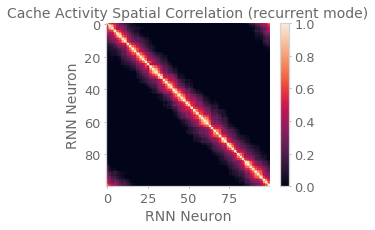

Sparsity: 0.116388


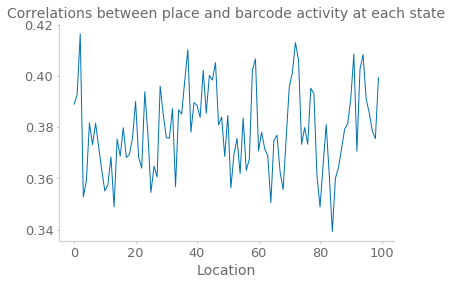

Now I just cached at location: 0


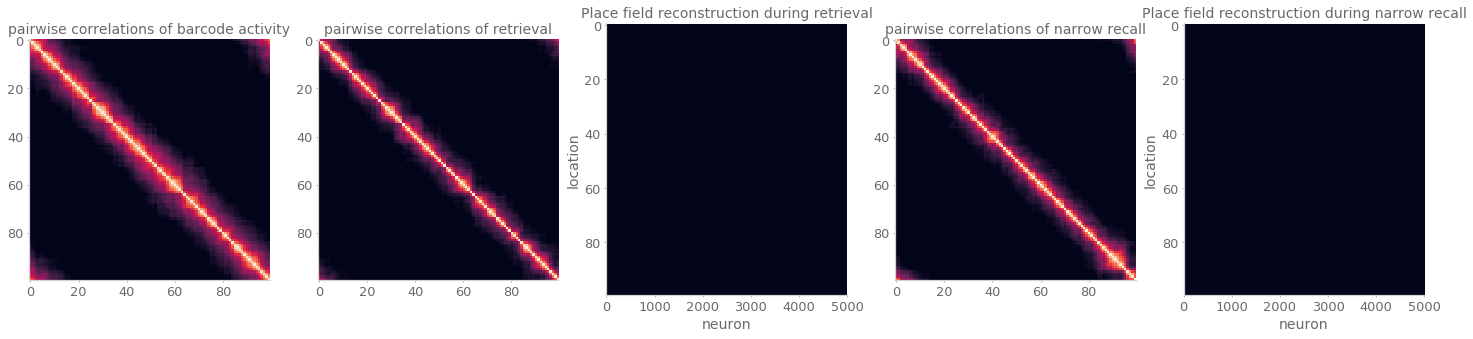

Now I just cached at location: 2


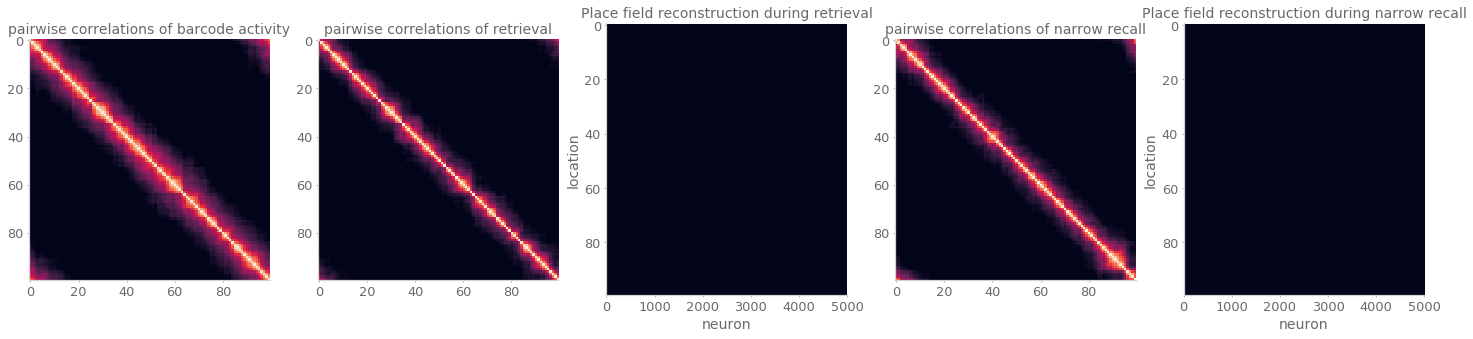

Now I just cached at location: 4


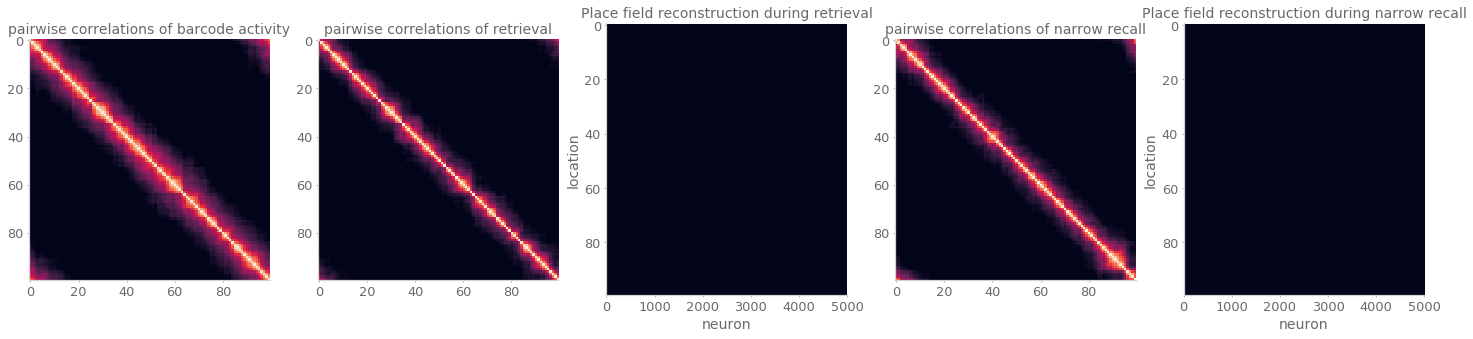

Now I just cached at location: 6


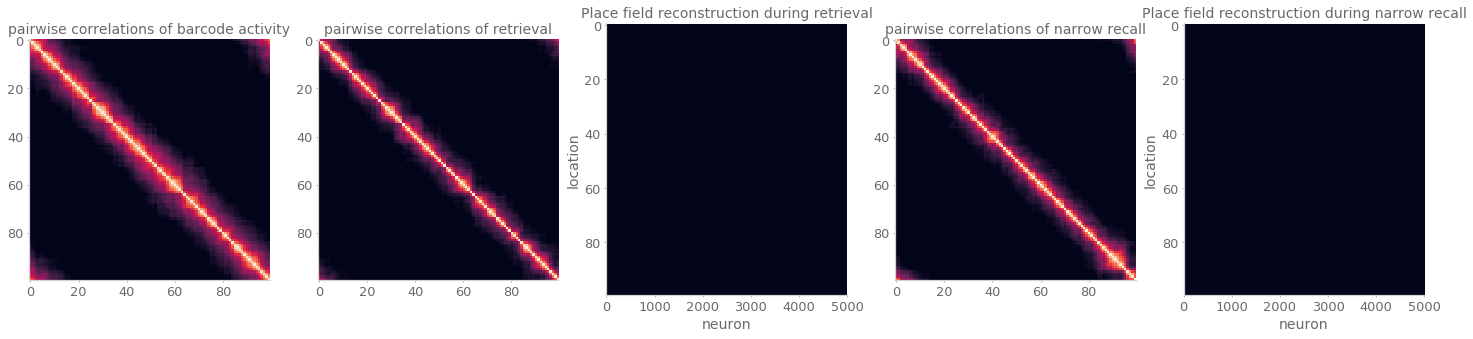

Now I just cached at location: 8


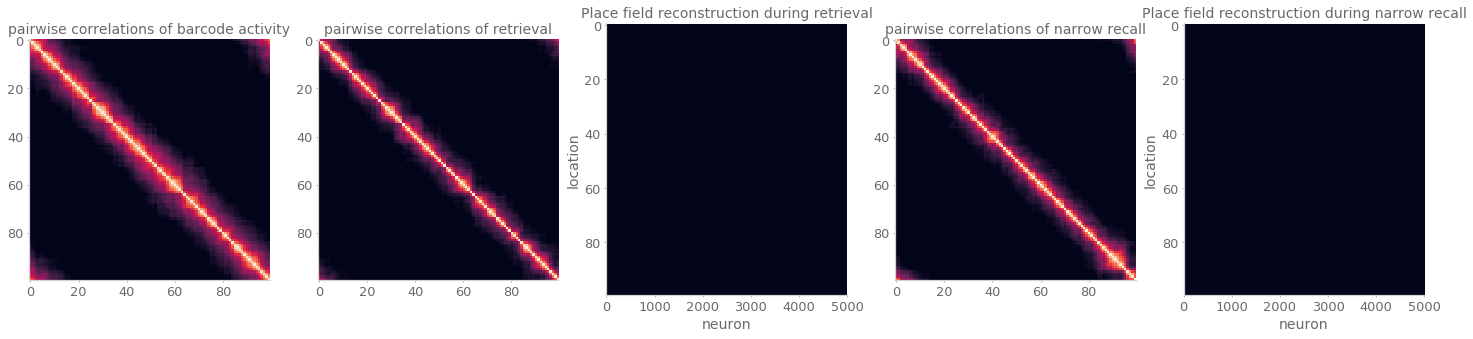

Now I just cached at location: 10


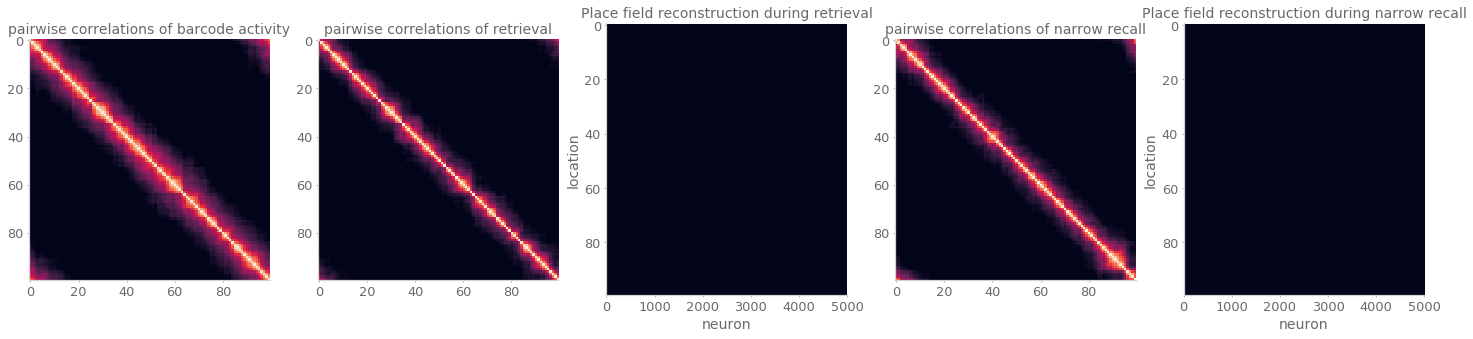

Now I just cached at location: 12


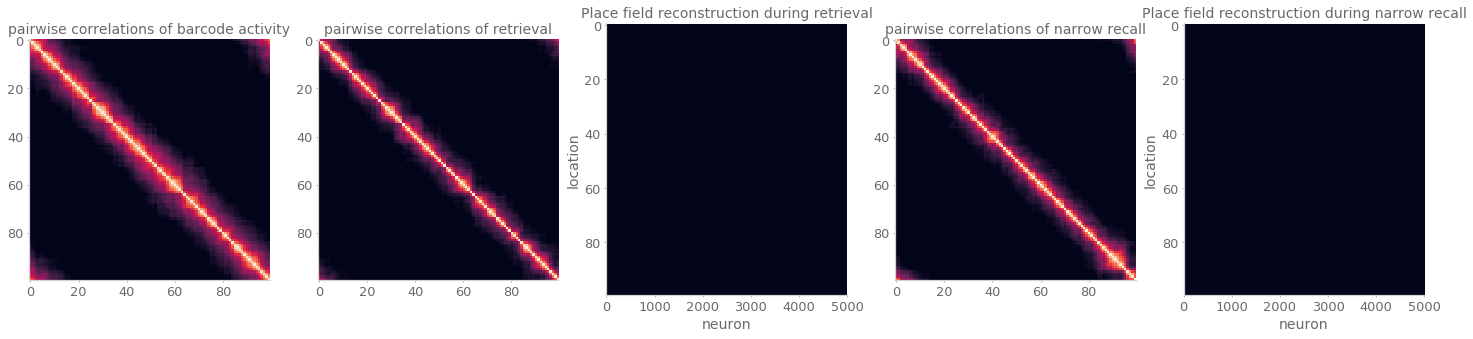

Now I just cached at location: 14


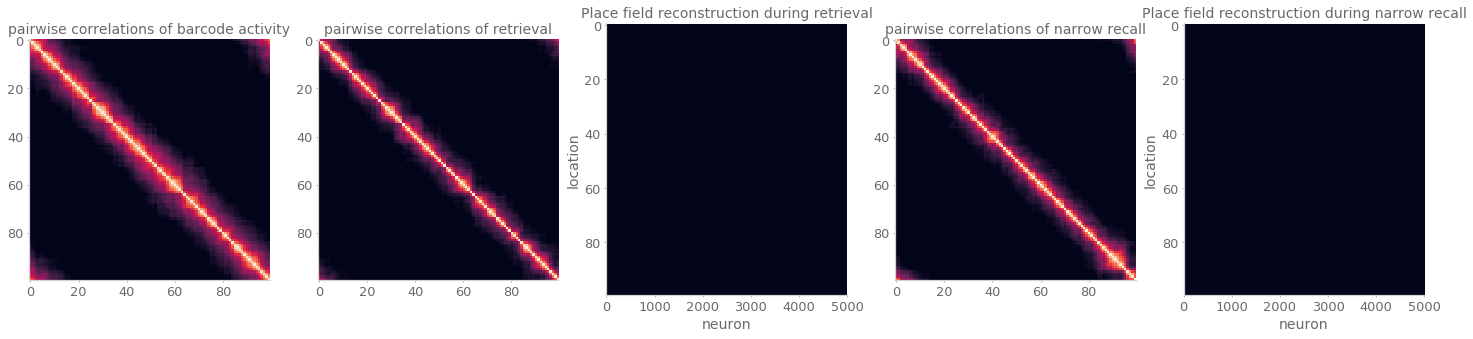

Now I just cached at location: 16


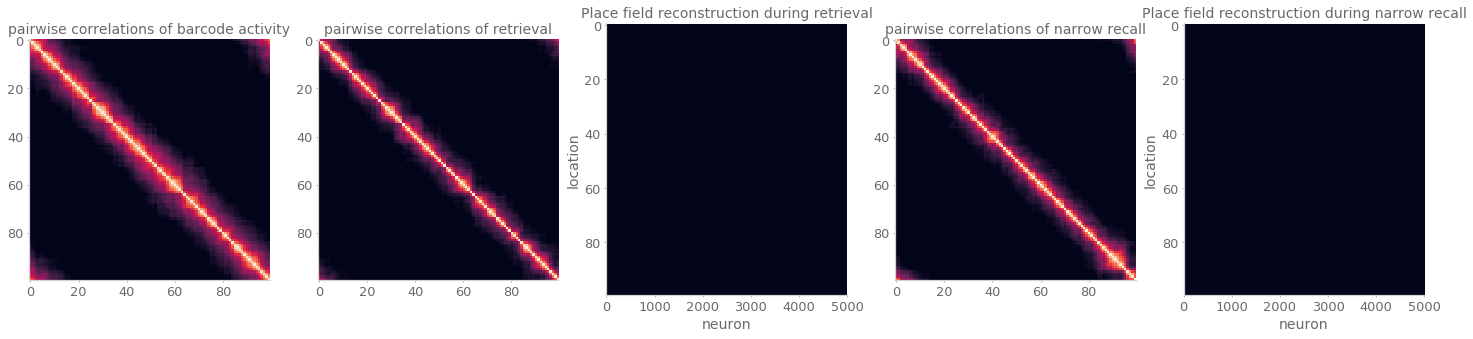

Now I just cached at location: 18


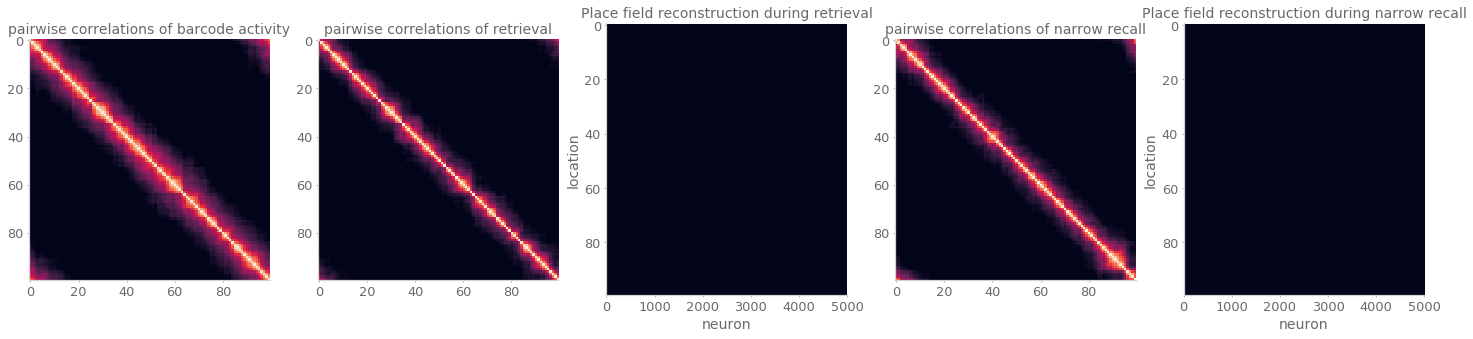

Now I just cached at location: 20


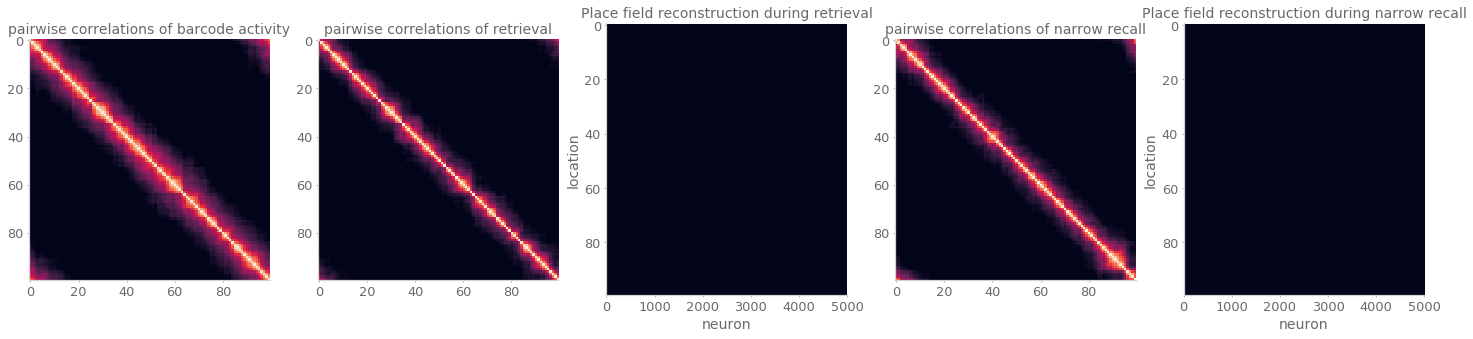

Now I just cached at location: 22


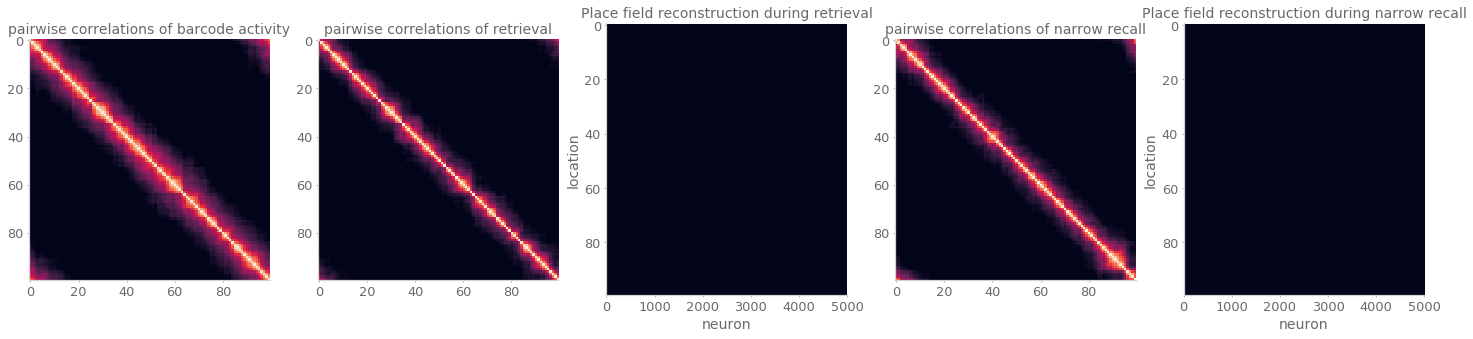

Now I just cached at location: 24


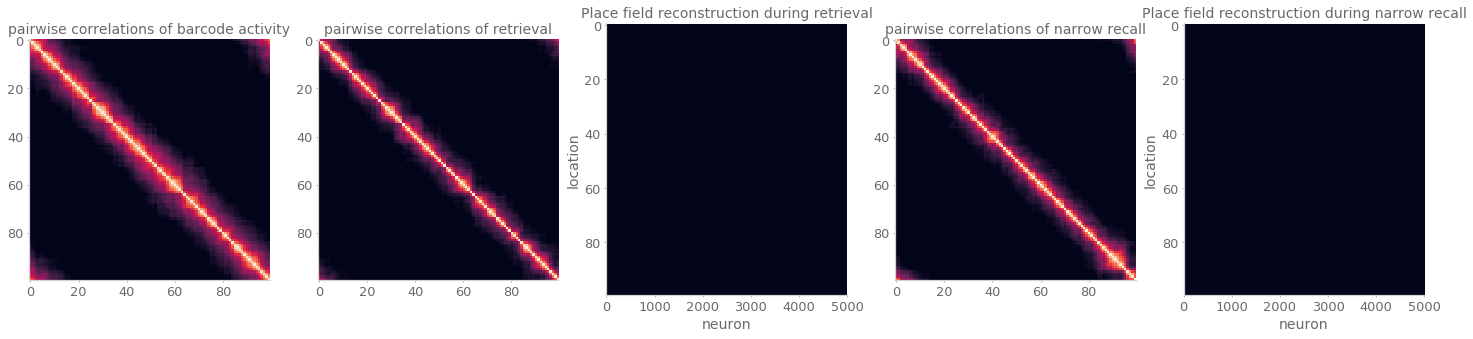

Now I just cached at location: 26


In [ ]:
model.reset()
cache_acts = []
cache_acts_over_time = []
retrieval_acts_over_time = []
figsize=(4,3)

_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_acts, axis=0).flatten()
place_std = np.std(place_acts, axis=0).flatten()
plt.figure(figsize=figsize)
plt.imshow(place_acts, vmin=0,  aspect='auto')
plt.xlabel("Input Neuron")
plt.ylabel("Location")
plt.colorbar()
plt.title("Input Activity")
plt.show()

plt.figure(figsize=figsize)
plt.imshow(pairwise_correlations_centered(place_acts), vmin=0, vmax=1)
plt.colorbar()
plt.title("Input Activity Spatial Correlation")
plt.xlabel("Input Neuron")
plt.ylabel("Input Neuron")
plt.show()

_, acts, _, _ = model.run_recurrent(place_inputs)
plt.figure(figsize=figsize)
plt.imshow(acts, vmin=0, vmax=1, aspect='auto')
plt.xlabel("RNN Neuron")
plt.ylabel("Location")
plt.colorbar()
plt.title("Cache Activity (recurrent mode)")
plt.show()

plt.figure(figsize=figsize)
plt.imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
plt.xlabel("RNN Neuron")
plt.ylabel("RNN Neuron")
plt.colorbar()
plt.title("Cache Activity Spatial Correlation (recurrent mode)")
plt.show()

print(f'Sparsity: {np.mean(acts>0)}')

acts_normalized = normalize(acts, ax=0)
inputs_normalized = normalize(place_acts, ax=0)
corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
plt.title("Correlations between place and barcode activity at each state")
plt.xlabel("Location")
plt.plot(corrs)
plt.show()

for cache_state in cache_states:
    
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    cache_acts.append(acts.copy())
    cache_acts_over_time.append(acts_over_time.copy())
    
    _, acts, _, _ = model.run_recurrent(place_inputs)
    ax[0].set_title("pairwise correlations of barcode activity")
    ax[0].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)

    _, acts, reconstruct, acts_over_time = model.run_recall(0, place_inputs)
    ax[1].set_title("pairwise correlations of retrieval")
    ax[1].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    ax[2].set_xlabel("neuron")
    ax[2].set_ylabel("location")
    ax[2].imshow(reconstruct, aspect='auto')
    ax[2].set_title("Place field reconstruction during retrieval")
    retrieval_acts_over_time.append(acts_over_time.copy())
    
    _, acts, reconstruct, _ = model.run_narrow_recall(place_inputs)
    ax[3].set_title("pairwise correlations of narrow recall")
    ax[3].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    ax[4].set_xlabel("neuron")
    ax[4].set_ylabel("location")
    ax[4].imshow(reconstruct, aspect='auto')
    ax[4].set_title("Place field reconstruction during narrow recall")
    plt.show()
    

In [ ]:
preacts, acts, rr, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)

# Define cache activity as a mean over some time window

In [ ]:
start_t = steps-25 # Start of time window

In [ ]:
avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = cache_acts_over_time[i][start_t:steps, location, :].mean(axis=0)
    avg_cache_acts.append(vec)
avg_cache_acts = np.array(avg_cache_acts)

In [ ]:
cache_mean = avg_cache_acts.mean(axis=0)

In [ ]:
avg_retrieval_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = retrieval_acts_over_time[i][start_t:steps, location, :].mean(axis=0)
    avg_retrieval_acts.append(vec)
avg_retrieval_acts = np.array(avg_retrieval_acts)

# Fig 3ab, Fig 4: cache v. visit correlation

In [ ]:
poiss_scale = 0.1

In [ ]:
cache_cache_corr = {'Distance': [], 'Correlation': []}
cache_visit_corr = {'Distance': [], 'Correlation': []}
visit_visit_corr = {'Distance': [], 'Correlation': []}

for i in range(len(cache_states)):
    for j in range(i, len(cache_states)):
        _distance = distance(cache_states[i], cache_states[j], num_states)
        
        cache_act_i = avg_cache_acts[i].copy()
        cache_act_j = avg_cache_acts[j].copy()
        place_act_i = place_acts[cache_states[i]].copy()
        place_act_j = place_acts[cache_states[j]].copy()
        
        for _ in range(1): # More samples
            c_c_corr = poiss_corr(cache_act_i, cache_act_j, scale=poiss_scale)
            c_v_corr = poiss_corr(cache_act_i, place_act_j, scale=poiss_scale)
            v_v_corr = poiss_corr(place_act_i, place_act_j, scale=poiss_scale)

            cache_cache_corr['Distance'].append(_distance)
            cache_cache_corr['Correlation'].append(c_c_corr)

            cache_visit_corr['Distance'].append(_distance)
            cache_visit_corr['Correlation'].append(c_v_corr)

            visit_visit_corr['Distance'].append(_distance)
            visit_visit_corr['Correlation'].append(v_v_corr)
            
cache_retrieval_corr = []
for i in range(len(cache_states)):
    cache_act_i = avg_cache_acts[i].copy()
    retrieval_act_i = avg_retrieval_acts[i].copy()
    c_r_corr = poiss_corr(cache_act_i, retrieval_act_i, scale=poiss_scale)
    cache_retrieval_corr.append(c_r_corr)

In [ ]:
plt.figure(figsize=(3,2))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Cache', color='C0',
    data=pd.DataFrame(cache_cache_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Visit', color='C1',
    data=pd.DataFrame(cache_visit_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Visit-Visit', color='C2',
    data=pd.DataFrame(visit_visit_corr))
plt.scatter(
    0, np.mean(cache_retrieval_corr),
    color='purple', marker='x', s=30)
plt.legend()
plt.show()

# Fig 3c: Example barcodes

In [ ]:
poiss_scale = 0.2

In [ ]:
noisy_avg_cache_acts = poisson(poiss_scale*avg_cache_acts).rvs().astype(float)
noisy_cache_mean = np.mean(noisy_avg_cache_acts, axis=0)

In [ ]:
noisy_place_acts = poisson(poiss_scale*place_acts).rvs().astype(float)
noisy_place_mean = np.mean(noisy_place_acts, axis=0).flatten()
noisy_place_std = np.std(noisy_place_acts, axis=0).flatten()

In [ ]:
barcodes = []
place_codes = []
for i in range(len(cache_states)):
    location = cache_states[i]
    
    # Cache activations
    _cache_act = noisy_avg_cache_acts[i].copy()
    _cache_act -= noisy_cache_mean
    
    # Place activations
    _place_act = noisy_place_acts[location].copy()
    _place_act -= noisy_place_mean
    _place_act /= np.linalg.norm(_place_act)
    place_codes.append(_place_act)
    
    # Define barcode
    projection = np.dot(_cache_act, _place_act) * _place_act
    barcode = _cache_act - projection
    barcodes.append(barcode)

In [ ]:
# Chettih et al Figure 3
x = np.array(barcodes)
plt.figure(figsize=(2.5,2))
plt.imshow(x, cmap='seismic', interpolation='nearest', aspect='auto')
plt.clim(-x.max(), x.max())
plt.colorbar()
plt.ylabel('Cache')
plt.xlabel('Neural Activity')
plt.show()

In [ ]:
# Chettih et al Figure 3
x = np.array(place_codes)
plt.figure(figsize=(2.5,2))
plt.imshow(x, cmap='seismic', interpolation='nearest', aspect='auto')
plt.clim(-x.max(), x.max())
plt.colorbar()
plt.ylabel('Location')
plt.xlabel('Neural Activity')
plt.show()

# Fig 2: Barcode neuron participation

In [ ]:
poiss_scale = 0.2

In [ ]:
noisy_avg_cache_acts = poisson(poiss_scale*avg_cache_acts).rvs().astype(float)
noisy_cache_mean = np.mean(noisy_avg_cache_acts, axis=0)

In [ ]:
activities = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = avg_cache_acts[i].copy()
    activities.append((vec-place_mean)/(place_std))

In [ ]:
x = np.array(activities)
n_caches, n_neurons = x.shape
plt.figure(figsize=(3,2))
plt.hist(
    x.flatten(),
    weights=[1/x.size]*x.size)
plt.ylabel('Proportion of\nNeurons')
plt.xlabel('Z-Score Activity')
plt.show()

In [ ]:
_x = x.flatten()
_x = _x[_x < 0]
plt.hist(
    _x, weights=[1/_x.size]*_x.size)
plt.ylabel('Proportion of\nNeurons')
plt.xlabel('Z-Score Activity')
plt.show()

In [ ]:
_x = x.flatten()
_x = _x[_x >= 0]
plt.hist(
    _x, weights=[1/_x.size]*_x.size)
plt.ylabel('Proportion of\nNeurons')
plt.xlabel('Z-Score Activity')
plt.show()

In [ ]:
vals = []
for i in range(x.shape[1]):
    _x = x[:,i]
    p = np.sum(_x<0)/_x.sizea
    vals.append(p)
val = np.mean(vals)
print(f'Neurons fire under their place mean in {val*100:.2f} % of Caches')